## Quadtree tokenization examples with different patch scorers

In [1]:
%load_ext autoreload
%autoreload 2
import setup

In [2]:
from functools import partial
from pathlib import Path

import numpy as np
import torch
from PIL import Image, ImageOps
from utils import hstack_images, transforms_imagenet_eval

from mixed_res.patch_scorers.feature_based_patch_scorer import FeatureBasedPatchScorer
from mixed_res.patch_scorers.pixel_blur_patch_scorer import \
    PixelBlurPatchScorer
from mixed_res.patch_scorers.precomputed_patch_scorer import \
    PrecomputedPatchScorer
from mixed_res.patch_scorers.random_patch_scorer import RandomPatchScorer
from mixed_res.quadtree_impl.quadtree_z_curve import ZCurveQuadtreeRunner
from mixed_res.render import render_quadtree, tensor_to_pil_image

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image_dir = Path("imagenet_val/images")
oracle_dir = Path("imagenet_val/oracle_importance_maps")

all_image_paths = list(image_dir.rglob("*.JPEG"))
image_transform = transforms_imagenet_eval(img_size=256)

quadtree_runner = ZCurveQuadtreeRunner(
    num_patches=64, min_patch_size=16, max_patch_size=64)

patch_scorers = [(FeatureBasedPatchScorer(device=device), "Feature-Based patch scorer -- our main method"),
                 (PrecomputedPatchScorer(), "Grad-CAM oracle patch scorer -- used for analysis"),
                 (PixelBlurPatchScorer(), "Pixel-Blur patch scorer -- used in Quadtrees for image compression"),
                 (RandomPatchScorer(), "Random patch scorer")]


### Run this cell multiple times to see results for different images:

Feature-Based patch scorer -- our main method


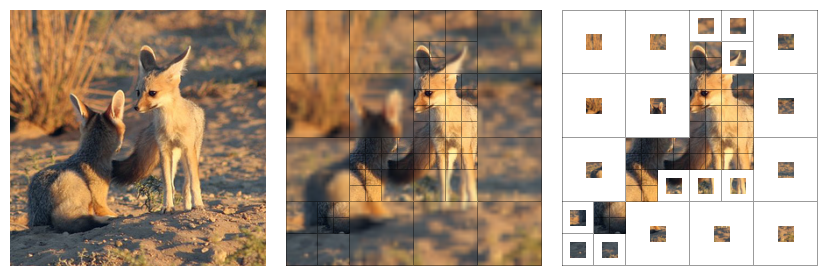

Grad-CAM oracle patch scorer -- used for analysis


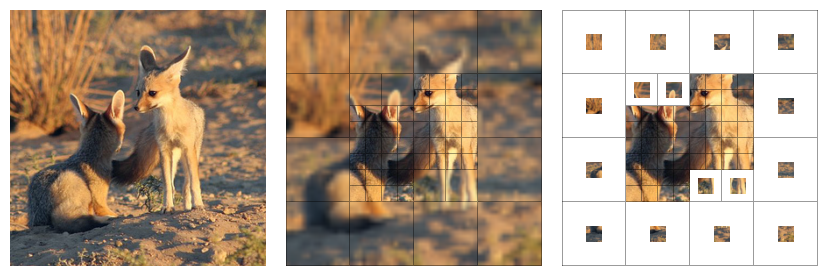

Pixel-Blur patch scorer -- used in Quadtrees for image compression


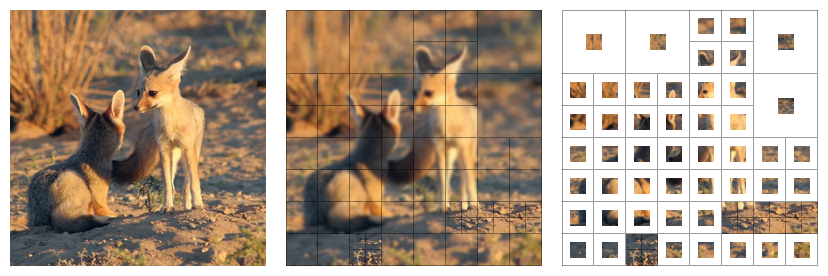

Random patch scorer


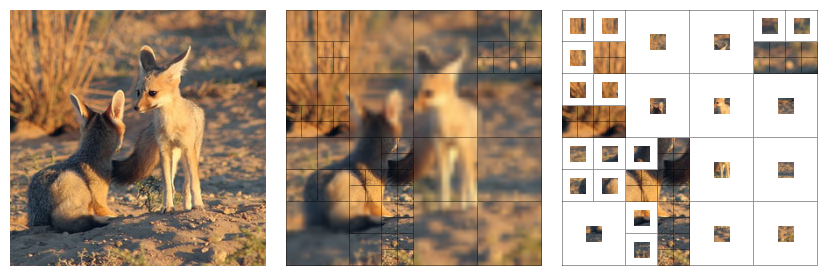

In [4]:
image_path = np.random.choice(all_image_paths)
oracle_path = oracle_dir / image_path.relative_to(image_dir).with_suffix(".pt")

images = image_transform(Image.open(image_path)).unsqueeze(0).to(device)
oracle_importance_maps = torch.load(oracle_path).unsqueeze(0).to(device)

for patch_scorer, display_name in patch_scorers:
    print(display_name)

    score_func = patch_scorer
    if isinstance(patch_scorer, PrecomputedPatchScorer):
        score_func = partial(patch_scorer, importance_maps=oracle_importance_maps)

    model_inputs = quadtree_runner.run_batch_quadtree(images, score_func)

    orig_image = tensor_to_pil_image(images[0])
    to_vis = [orig_image]
    for mini_patches in (False, True):
        rendering = render_quadtree(images[0], model_inputs[0], show_lines=True, mini_patches=mini_patches,
                                    blur=not mini_patches, line_color_rgba=(0, 0, 0, 100))
        to_vis.append(rendering)
    to_vis = hstack_images(to_vis)
    to_vis = ImageOps.expand(to_vis, border=10, fill=(255, 255, 255))
    display(to_vis)
